

## **Introduction Outline**

1. **Import Libraries:**
   - Set up Python libraries required for data handling, visualization, and modeling.

2. **Load and Explore the Dataset:**
   - Understand the structure of the dataset.
   - Identify missing values, outliers, and key patterns.

3. **Clean and Engineer Data:**
   - Handle missing data and outliers.
   - Create time-based and lagged features for better model performance.

4. **Model Building:**
   - Train two models:
     - **XGBoost**: A machine learning-based approach.
     - **Prophet**: A time-series forecasting approach.

5. **Evaluate Model Performance:**
   - Compare the models using metrics like:
     - **R² Score**: Measures how much variance in the data is explained.

6. **Visualize Predictions:**
   - Plot actual vs. predicted courier activity for both models.
   - Highlight patterns, trends, and seasonal effects.

7. **Results:**
   - Summarize the key findings, including:
     - Which model performed better.
     - How the models compare in handling trends and seasonality.

8. **Conclusion:**
   - Summarize the key takeaways from the project.
   - Explain how the insights can be applied to Wolt’s operations.
   - Identify the model best suited for the task.

9. **Suggestions for Improvement:**
   - Discuss potential enhancements, including:
     - Adding new features (e.g., public holidays, promotions).
     - Testing advanced models like LSTMs.
     - Extending forecast horizons.


In [24]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


## **Import Libraries**

In this step, we will import the necessary Python libraries required for data manipulation, visualization, and modeling. These include:
- `pandas` and `numpy` for data handling and numerical computations.
- `matplotlib` for data visualization.
- `xgboost` for machine learning modeling.
- `prophet` for time-series forecasting.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet
import plotly 

# **Visualizing Data Distributions**

We use the `plot_histograms` function to plot histograms for numeric features:
- `courier_partners_online`: Number of couriers online.
- `temperature`: Daily temperature values.
- `relative_humidity`: Percentage of humidity.
- `precipitation`: Daily rainfall.

This step helps identify potential outliers and understand feature distributions.


In [26]:
def plot_histograms(data):
    plt.figure(figsize=(7, 5))
    data['courier_partners_online'].hist(bins=50, edgecolor='black')
    plt.title('Courier')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    data['temperature'].hist(bins=50, edgecolor='black')
    plt.title('Temperature')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    data['relative_humidity'].hist(bins=50, edgecolor='black')
    plt.title('Relative humidity')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 5))
    data['precipitation'].hist(bins=50, edgecolor='black')
    plt.title('Precipitation')
    plt.tight_layout()
    plt.show()

# **Visualizing Time-Series Data**

Using the `plot_date` function, we plot trends over time for:
- `courier_partners_online`.
- Weather-related features (temperature, humidity, precipitation).

This helps uncover seasonal patterns and correlations between variables.


In [4]:
def plot_date(df):
    # Ensure 'date' is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Create subplots
    num_cols = 2  
    num_rows = 2  
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()

    # Plot 'courier_partners_online'
    axes[0].plot(df['date'], df['courier_partners_online'], label='courier_partners_online', alpha=0.8)
    axes[0].set_title('Courier')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Value')
    axes[0].legend(loc='upper right')
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # Customize months as needed
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Plot 'temperature'
    axes[1].plot(df['date'], df['temperature'], label='temperature', alpha=0.8)
    axes[1].set_title('Temperature')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Value')
    axes[1].legend(loc='upper right')
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # Customize months as needed
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Plot 'relative_humidity'
    axes[2].plot(df['date'], df['relative_humidity'], label='relative_humidity', alpha=0.8)
    axes[2].set_title('Relative humidity')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Value')
    axes[2].legend(loc='upper right')
    axes[2].xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # Customize months as needed
    axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Plot 'precipitation'
    axes[3].plot(df['date'], df['precipitation'], label='precipitation', alpha=0.8)
    axes[3].set_title('Precipitation')
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('Value')
    axes[3].legend(loc='upper right')
    axes[3].xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))  # Customize months as needed
    axes[3].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.tight_layout()
    plt.show()


# **Cleaning the Data**

The `data_cleaning` function performs the following tasks:
1. Replaces outliers (e.g., values >200 in `courier_partners_online`) with `NaN`.
2. Imputes missing values using the KNN Imputer.

This ensures that the dataset is clean and ready for modeling.


In [5]:
def data_cleaning(raw_data):

    raw_data.loc[raw_data['courier_partners_online'] > 200, 'courier_partners_online'] = np.nan
    
    numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])
    imputer = KNNImputer(n_neighbors=5)
    imputed_data = imputer.fit_transform(numeric_data)
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_data.columns, index=numeric_data.index)
    raw_data[numeric_data.columns] = imputed_df

    return raw_data


# **Exploratory Data Analysis**

We revisit EDA after cleaning the data to:
1. Confirm that missing values are resolved.
2. Re-visualize distributions and trends to ensure data integrity.


In [6]:

def inital_EDA(raw_data):
    
    print(raw_data.isnull().sum())
    plot_histograms(raw_data)
    plot_date(raw_data)

# **Post-Processing and Combining Results**

We use the `post_processing` function to:
1. Combine actual data with forecasts from both XGBoost and Prophet models.
2. Structure the results for easy comparison and visualization.



In [7]:
def post_processing(data, forecast_prophet, forecast_xgb):
    # print preds:
    df_orig = data.copy()
    df_orig = df_orig[["date", "courier_partners_online"]]
    df_orig = df_orig.rename(columns={"courier_partners_online": "courier"})
    print("PÄÄ: \n",df_orig)
    print("forecast_prophet: \n", forecast_prophet)
    print("forecast_xgb: \n", forecast_xgb)

    df_orig['date'] = pd.to_datetime(df_orig['date'])

    df_orig_extended = pd.concat([df_orig,
                             pd.DataFrame({'date': pd.date_range(df_orig['date'].max() + pd.Timedelta(days=1), periods=len(forecast_prophet)),
                                            'courier': np.nan})], ignore_index=True)

    df_xgb = pd.concat([forecast_xgb,
                             pd.DataFrame({'date': pd.date_range(end= forecast_xgb['date'].min() - pd.Timedelta(days=1), periods=len(df_orig)),
                                            'xgb_pred': np.nan})], ignore_index=True)
    
    df_prophet = pd.concat([forecast_prophet,
                             pd.DataFrame({'date': pd.date_range(end= forecast_prophet['date'].min() - pd.Timedelta(days=1), periods=len(df_orig)),
                                            'prophet_pred': np.nan})], ignore_index=True)
    

    final_df = (df_orig_extended.merge(df_xgb, on="date", how="inner").\
                merge(df_prophet, on="date", how="inner").\
                sort_values("date").reset_index(drop=True))
    return final_df


# **Feature Engineering**

Using the `create_features` and `lag_features` functions, we engineer new variables to improve model performance:
- **Time-based features**: Day of the week, month, quarter, year, etc.
- **Lag features**: Values from 1 year, 2 years, and 3 years prior for `courier_partners_online`.



In [8]:
def create_features(data):
    """
    Create tiem series features based on time series index.
    """
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['year'] = data.index.year
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['dayofyear'] = data.index.dayofyear
    data['daysinmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    return data


In [9]:
def lag_features(data):
    target_map = data["courier_partners_online"].to_dict()
    data["lag1"] = (data.index - pd.Timedelta("364 days")).map(target_map)
    data["lag2"] = (data.index - pd.Timedelta("728 days")).map(target_map)
    data["lag3"] = (data.index - pd.Timedelta("1092 days")).map(target_map)
    return data

# **Modeling with XGBoost**

Here, we train an XGBoost model for time-series forecasting:
1. Use lag features and time-based variables as predictors.
2. Perform time-series cross-validation to evaluate the model.
3. Forecast courier activity for the next 30 days using the trained model.

Evaluation metrics include:
- R² Score: Measures how well the model explains variance.
- RMSE: Measures the average error in predictions.


In [10]:
def cross_validation(data, days, plot = False):
    tss = TimeSeriesSplit(n_splits=5, test_size=days)
    df = data.sort_index()
    fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    
    fold = 0
    preds = []
    scores = []
    for train_idx, val_idx in tss.split(df) :
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        if plot:
            train['courier_partners_online'].\
                plot(ax=axs[fold],
                    label='Training Set',
                    title=f'Data Train/Test Split Fold {fold}')

            test[ 'courier_partners_online' ].\
                plot(ax=axs[fold],
                    label= 'Test Set')
            
            axs[fold].axvline(test.index.min(), color='black', ls ='--')
            fold += 1
            

        train = create_features(train)
        test = create_features(test)
        FEATURES = ['dayofyear',
                    'hour',
                    'dayofweek', 
                    'quarter', 
                    'month', 
                    'year',
                    'lag1', 
                    'lag2', 
                    'lag3' ]
        TARGET = 'courier_partners_online'
        
        X_train = train[ FEATURES]
        y_train = train [TARGET]

        X_test = test [FEATURES]
        y_test = test [TARGET]
        
        reg = xgb.XGBRegressor (base_score=0.5,
                                booster='gbtree',
                                n_estimators=1000, 
                                early_stopping_rounds=50, 
                                objective='reg:linear', 
                                max_depth=3, 
                                learning_rate=0.01)
        
        reg.fit(X_train, y_train,
                eval_set=[ (X_train, y_train), (X_test, y_test)],
                verbose=100)
        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(r2_score(y_test, y_pred))
        scores.append(score)
    plt.show()
    print("scores: ", scores)
    print("mean value of scores: ", np.mean(scores))
    return np.mean(scores)

In [11]:
def prediction(df, days = 30, plot = False):
    # DO the prediction:
    df = create_features(df)
    FEATURES = ['dayofyear',
                'hour',
                'dayofweek', 
                'quarter', 
                'month', 
                'year',
                'lag1', 
                'lag2', 
                'lag3' ]
    TARGET = 'courier_partners_online'
    
    X_all = df[FEATURES]
    y_all = df[TARGET]
    
    reg = xgb.XGBRegressor (base_score=0.5,
                            booster='gbtree',
                            n_estimators=1000, 
                            early_stopping_rounds=50, 
                            objective='reg:linear', 
                            max_depth=3, 
                            learning_rate=0.01)
    
    reg.fit(X_all, y_all,
            eval_set=[ (X_all, y_all)],
            verbose=100)
    
    # Create the future data
    max_date = df.index.max()           
    end_date = max_date + pd.Timedelta(30, 'D')  
    future = pd.date_range(start=max_date, end=end_date, freq='D')

    

    future_df = pd.DataFrame (index=future)
    future_df ['isFuture'] = True
    df[ 'isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = create_features(df_and_future)
    df_and_future = lag_features(df_and_future)
    
    future_data = df_and_future.query("isFuture").copy()
    future_data['pred'] = reg.predict(future_data[FEATURES])

    future_data = future_data.reset_index().rename(columns={'index': 'date', 'pred': 'xgb_pred'})
    future_data = future_data[["date", "xgb_pred"]]
    
    return future_data

In [12]:
def forecast_courier_XGBoost(data, days = 30, plot = False):
    df = data.copy()
    df['date'] = pd.to_datetime(data['date'])
    df = df.set_index('date')
    df = df[['courier_partners_online']]

    df = lag_features(df)
    df = create_features(df)
    
    score = cross_validation(df, days = days, plot = plot)
    future_data = prediction(df, days = days, plot = plot)

    return future_data.tail(30).reset_index()[["date", "xgb_pred"]], score

# **Modeling with Prophet**

We train a time-series model using Facebook Prophet:
1. Prepare the data by renaming columns to `ds` (date) and `y` (target).
2. Train the model with automatic seasonality detection.
3. Generate a 30-day forecast and evaluate its performance using R² Score.


In [13]:

def modelling(data, plot = False):

    # Facebook's prophet model
    forecast_prophet, score_prophet = forecast_courier_prophet(data, plot = plot)


    # XGBoost
    forecast_xgb, score_xgb = forecast_courier_XGBoost(data, days=30, plot = plot)

    final_df = post_processing(data, forecast_prophet, forecast_xgb)
    print(final_df)
    print("score_xgb: ", score_xgb)
    print("score_prophet: ", score_prophet)

    return final_df, score_prophet, score_xgb


In [14]:

def prepare_data_for_prophet(data):
    """
    Prepares the dataset for Facebook Prophet.
    - Renames the date column to 'ds'.
    - Renames the target variable column to 'y'.
    """
    data = data[['date', 'courier_partners_online']].copy()  # Select relevant columns
    data.rename(columns={'date': 'ds', 'courier_partners_online': 'y'}, inplace=True)
    return data


In [15]:
def forecast_courier_prophet(data, plot = False):
    """
    Implements Facebook Prophet for forecasting courier partners online.
    """
    prophet_data = prepare_data_for_prophet(data)

    model = Prophet()
    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=30)  # Forecast 30 days ahead
    forecast = model.predict(future)

    if plot:
        # Plot the forecast
        model.plot(forecast)
        plt.show()
        model.plot_components(forecast)
        plt.show()  
    forecast = forecast.rename(columns={"ds": "date", "yhat": "prophet_pred"})
    forecast = forecast[["date", "prophet_pred"]]

    forecast['date'] = pd.to_datetime(forecast['date'], errors='coerce')    
    data['date'] = pd.to_datetime(data['date'], errors='coerce')  

    metric_df = forecast.set_index('date')[['prophet_pred']].join(data.set_index('date')[['courier_partners_online']]).reset_index()
    metric_df = data.merge(forecast, on='date', how='inner')
    score = r2_score(metric_df.courier_partners_online, metric_df.prophet_pred)
    
    return forecast.tail(30).reset_index()[["date", "prophet_pred"]], score


# **Visualizing Results**

Using the `post_EDA` function, we compare actual vs. predicted courier activity from:
1. XGBoost model.
2. Prophet model.

This visualization highlights the strengths and weaknesses of each model.


In [16]:
def post_EDA(final_df, score_prophet, score_xgb):
    """
    Visualizes columns of interest from final_df over time.
    Assumes final_df has a 'date' column and numeric columns like 'courier', 'xgb_pred', 'prophet_pred'.
    """

    
    final_df['date'] = pd.to_datetime(final_df['date'])

    start_date = final_df.loc[final_df['courier'].isna(), 'date'].min() - pd.DateOffset(months=6)

    final_df = final_df[(final_df['date'] >= start_date)]

    
    columns_to_plot = {'courier': r'$\mathbf{Actual\ data}$',
                        'xgb_pred': r'$\mathbf{XGBoost\ (R^2\ =\ %.3f)}$' % score_xgb,
                        'prophet_pred': r'$\mathbf{Prophet\ (R^2\ =\ %.3f)}$' % score_prophet}

    plt.figure(figsize=(10, 6))
    for col, label in columns_to_plot.items(): 
        plt.plot(final_df['date'], final_df[col], label=label, alpha=0.8)

    plt.xlabel('Date')
    plt.ylabel('Amount of couriers')
    plt.title('Visualization of actual and predicted data.')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [17]:
plot = True

In [18]:
# read the initial data
raw_data = pd.DataFrame(pd.read_csv("data/daily_cp_activity_dataset.csv"))

date                        0
courier_partners_online     0
temperature                30
relative_humidity           0
precipitation               5
dtype: int64


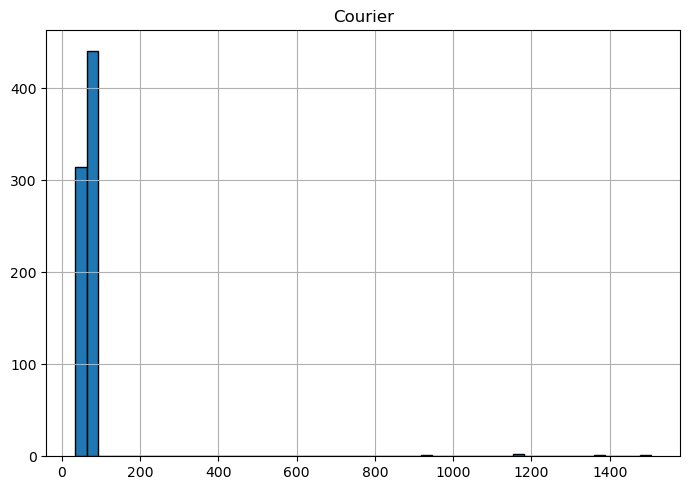

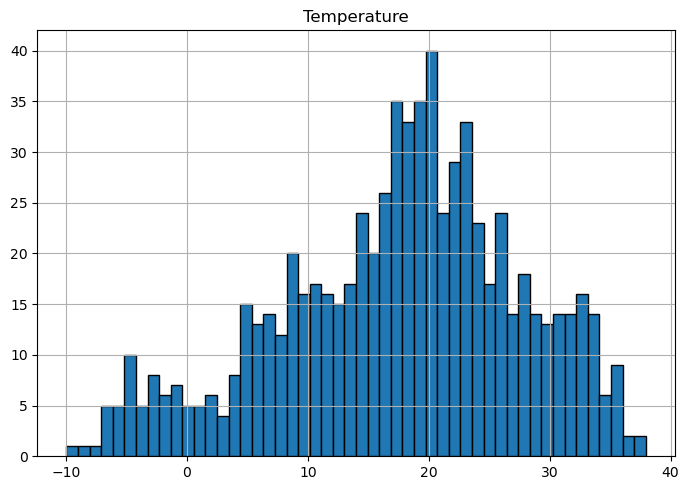

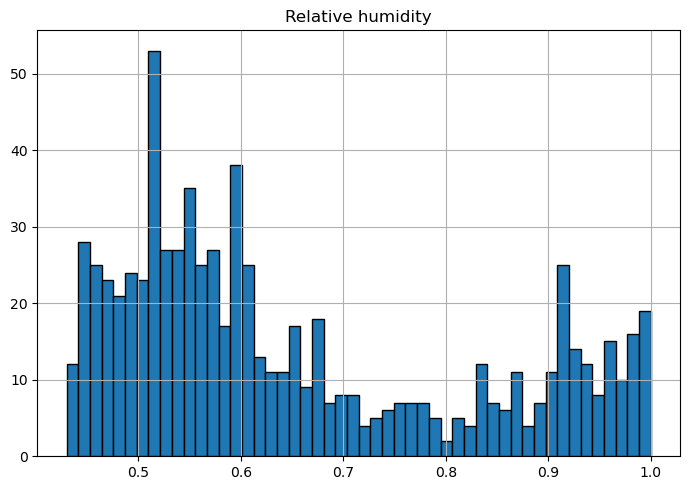

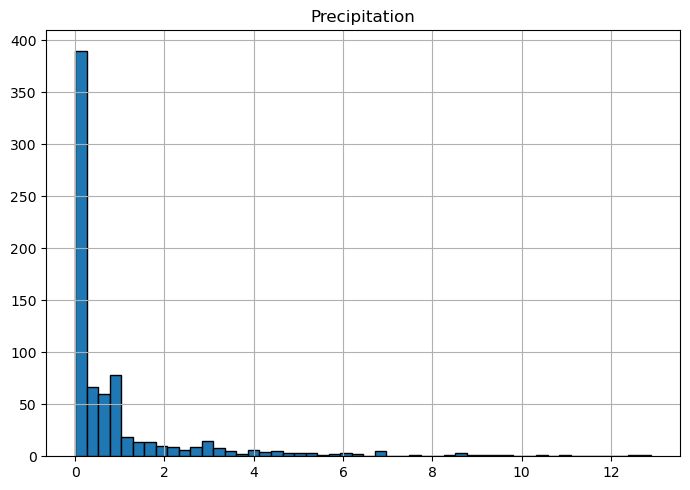

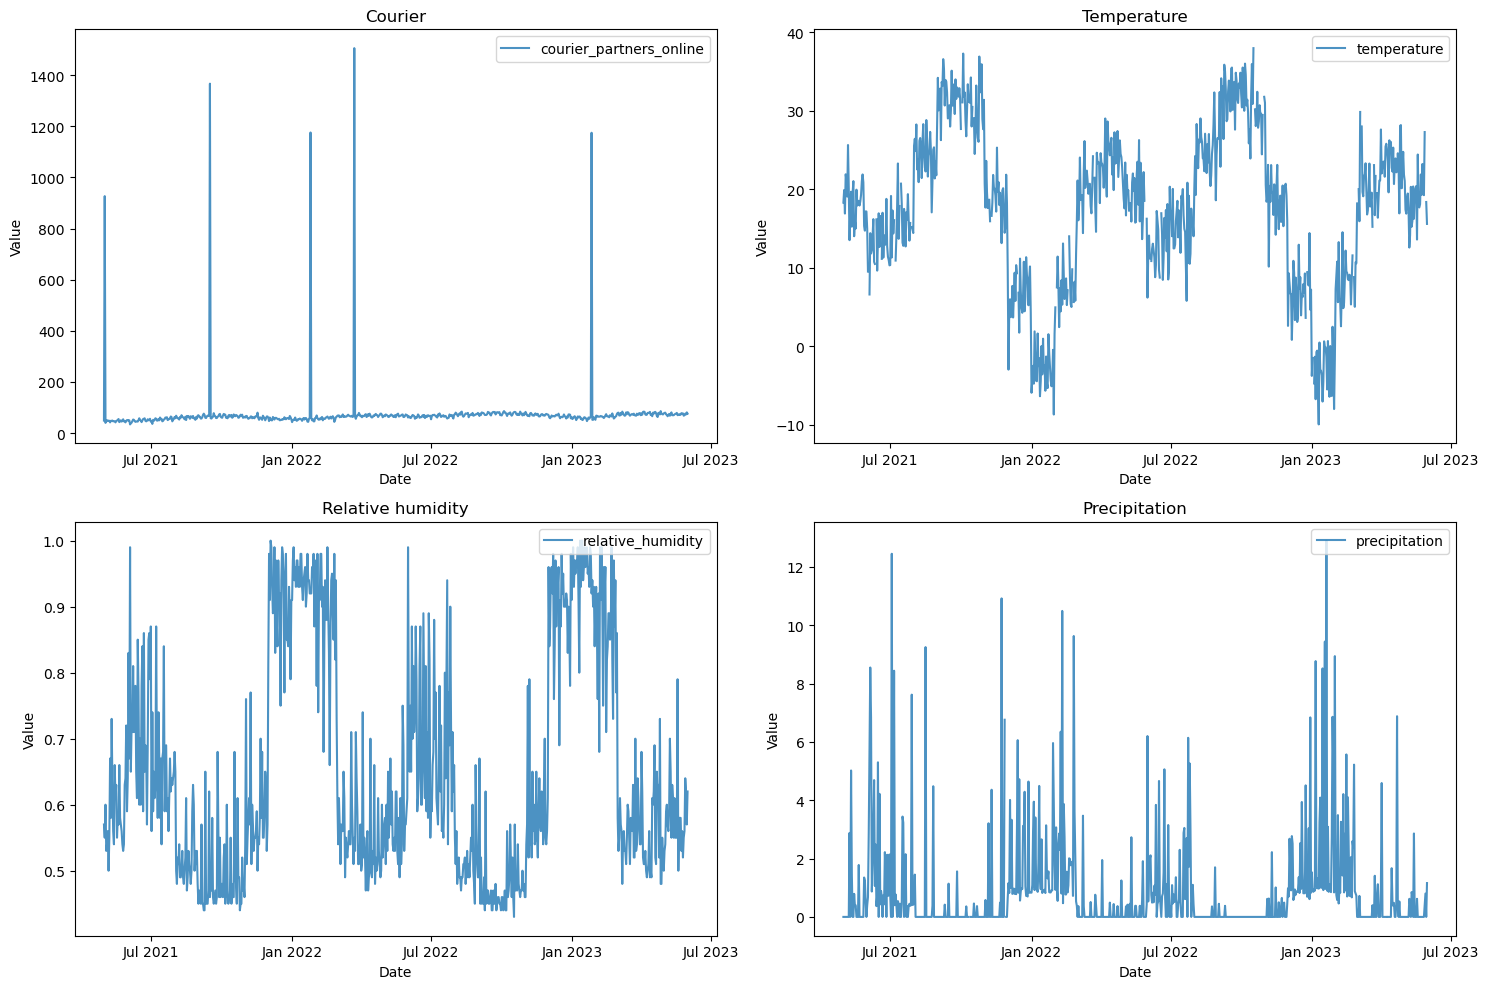

In [19]:
# Do the inital EDA
if plot:
    inital_EDA(raw_data)

In [20]:
# clean some outliers and fill the missing values.
data = data_cleaning(raw_data)

date                       0
courier_partners_online    0
temperature                0
relative_humidity          0
precipitation              0
dtype: int64


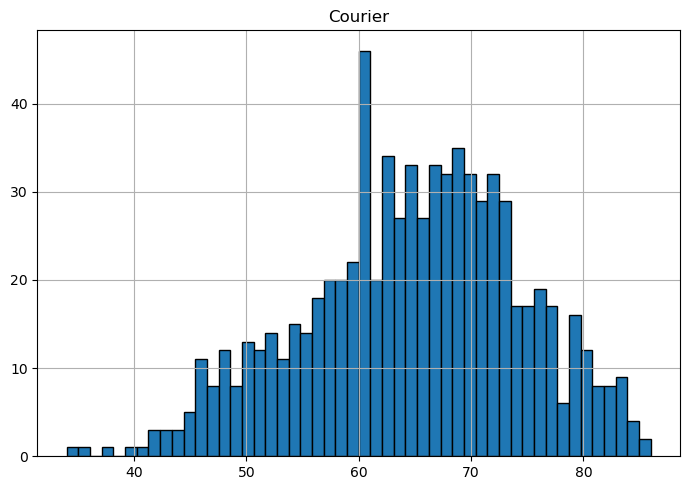

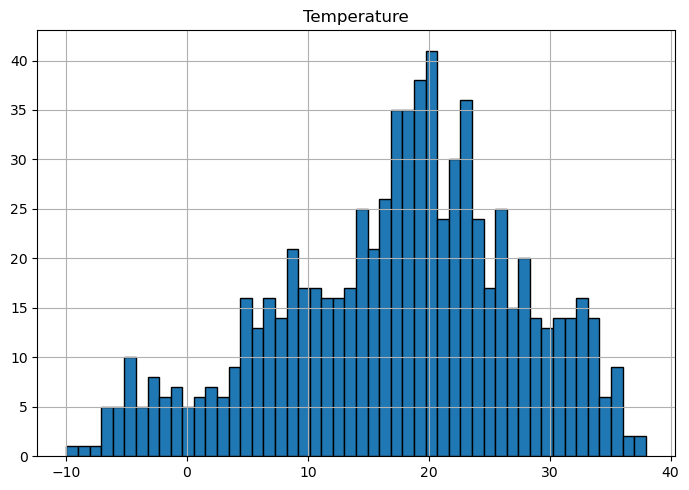

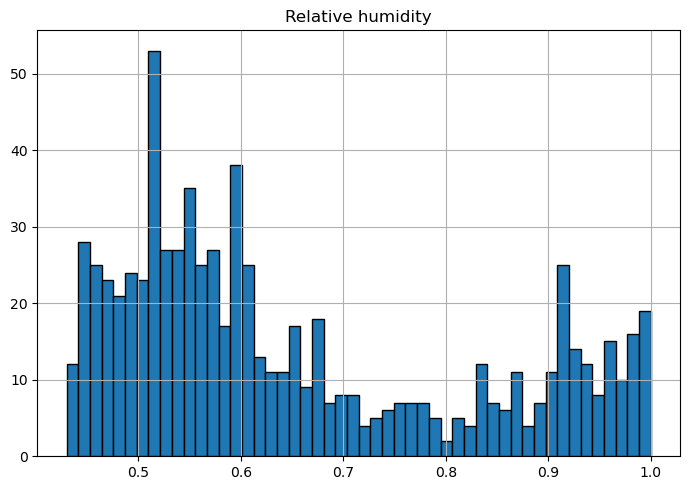

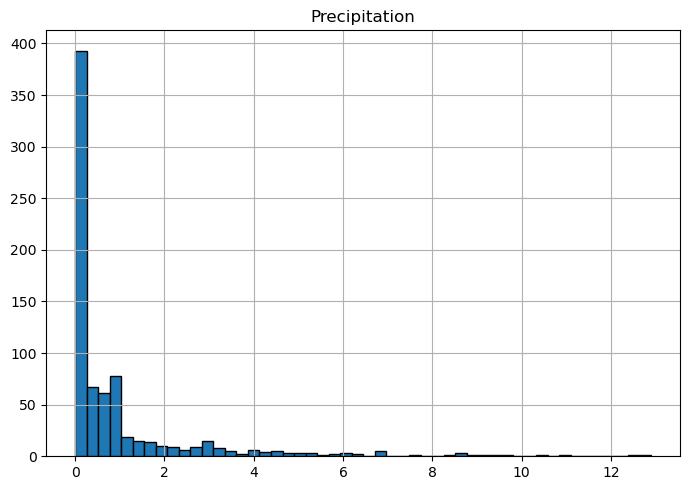

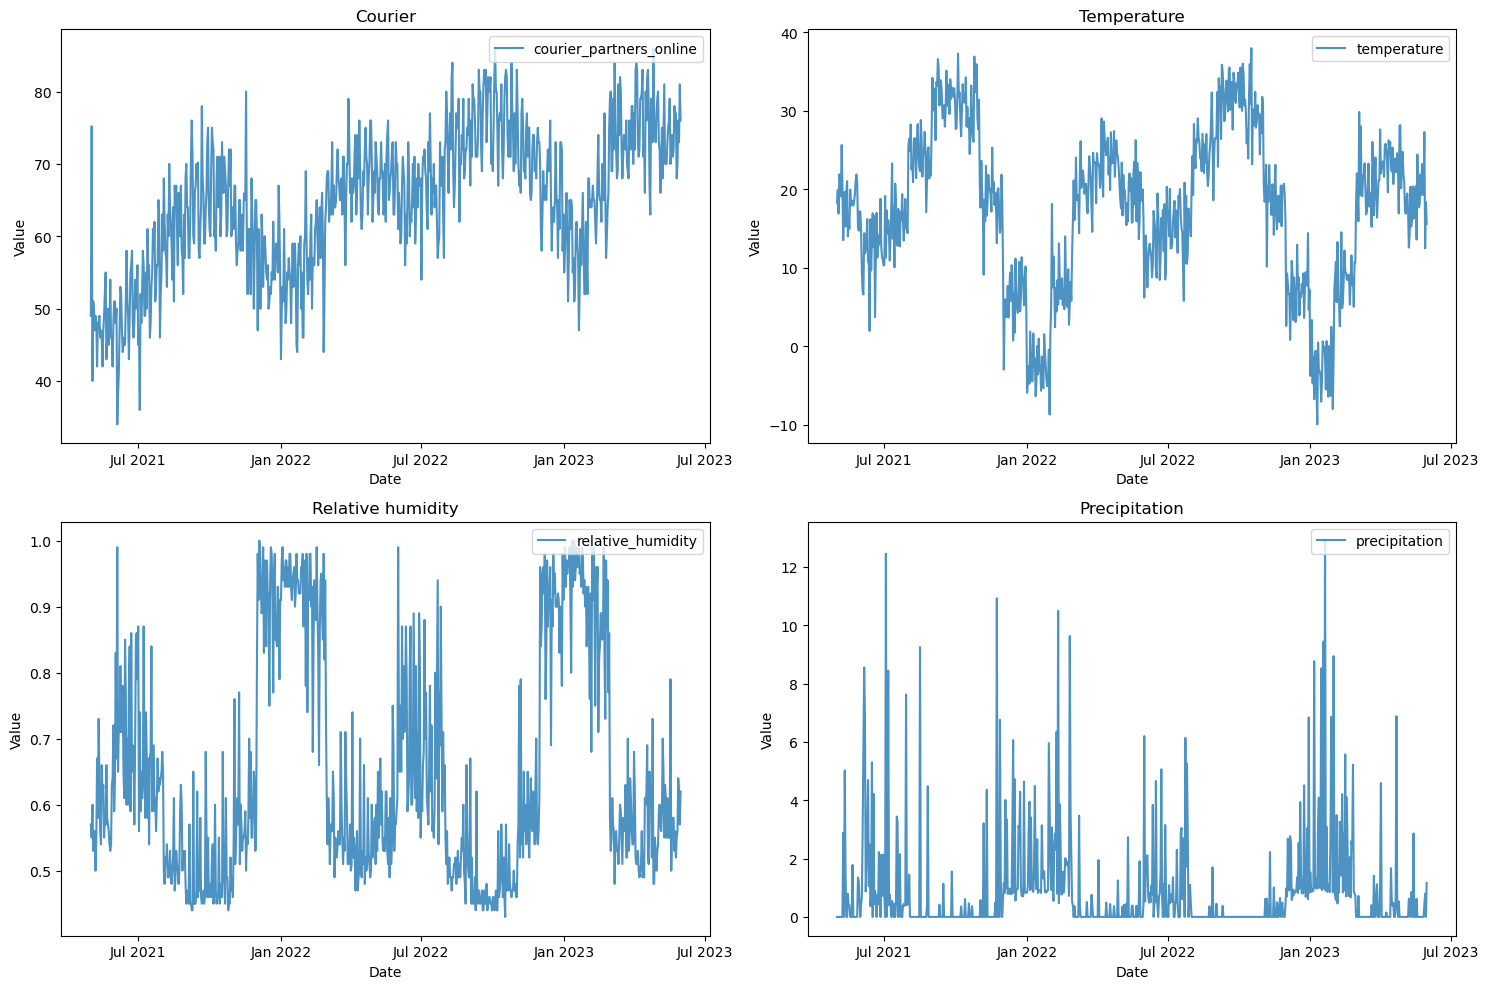

In [21]:
# Viewing the same plots after cleaning data
if plot:
    inital_EDA(data)

20:03:20 - cmdstanpy - INFO - Chain [1] start processing
20:03:20 - cmdstanpy - INFO - Chain [1] done processing


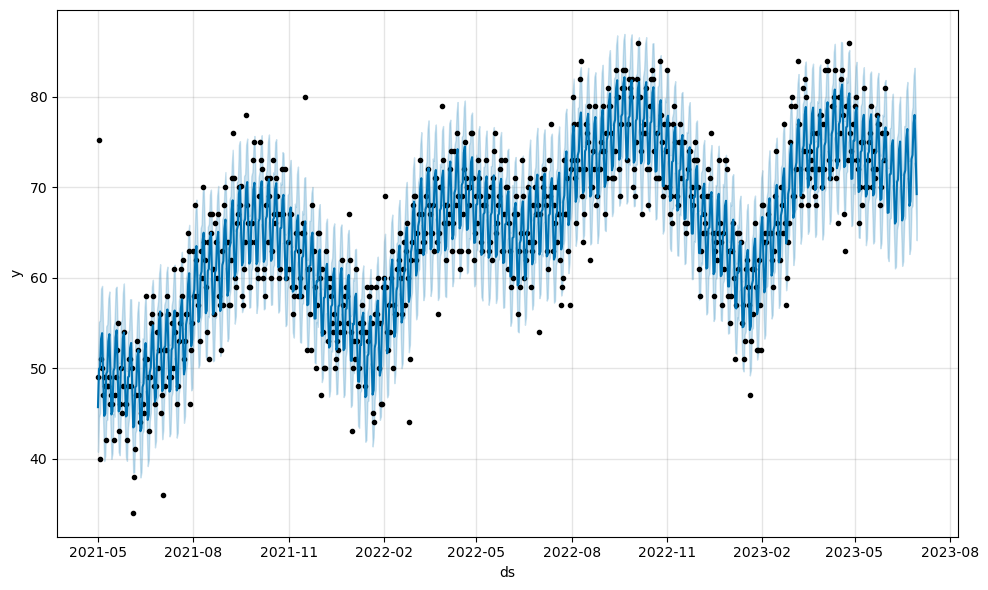

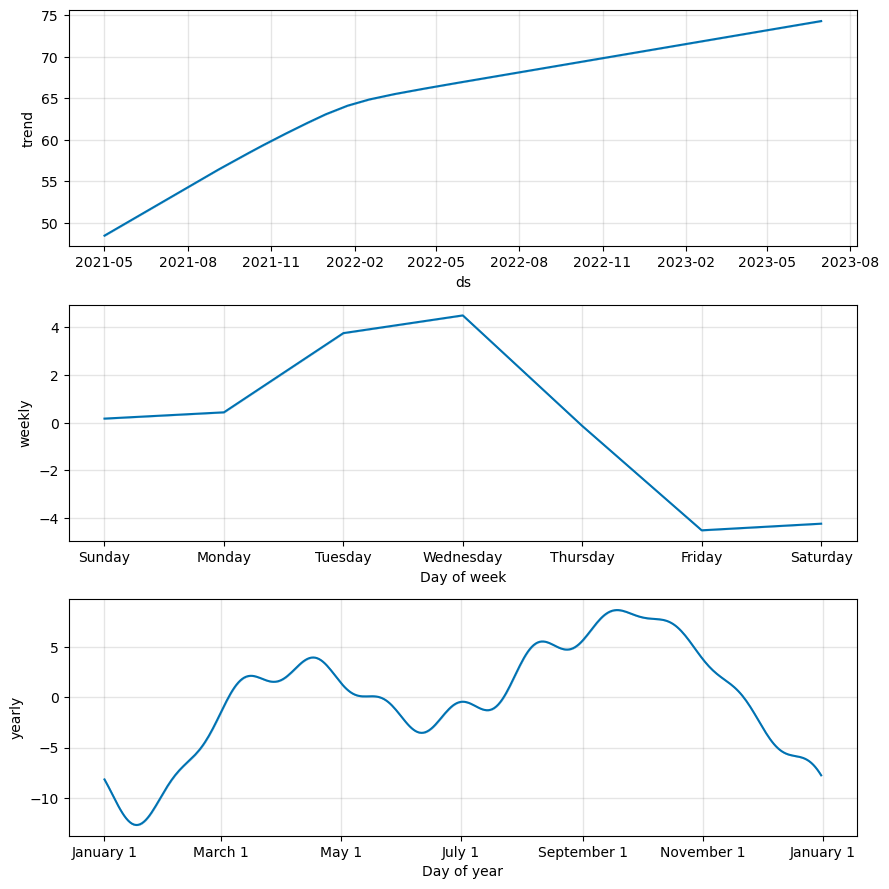

[20:03:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:63.14961	validation_1-rmse:57.12562
[100]	validation_0-rmse:23.90155	validation_1-rmse:18.64957
[200]	validation_0-rmse:9.85512	validation_1-rmse:7.31008
[300]	validation_0-rmse:5.29306	validation_1-rmse:4.85354
[400]	validation_0-rmse:4.08625	validation_1-rmse:4.74851
[408]	validation_0-rmse:4.04493	validation_1-rmse:4.75641
[20:03:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:62.88640	validation_1-rmse:65.92723
[100]	validation_0-rmse:23.78294	validation_1-rmse:25.37367
[200]	validation_0-rmse:9.79488	validation_1-rmse:11.36081
[300]	validation_0-rmse:5.29090	validation_1-rmse:6.50822
[400]	validation_0-rmse:4.10905

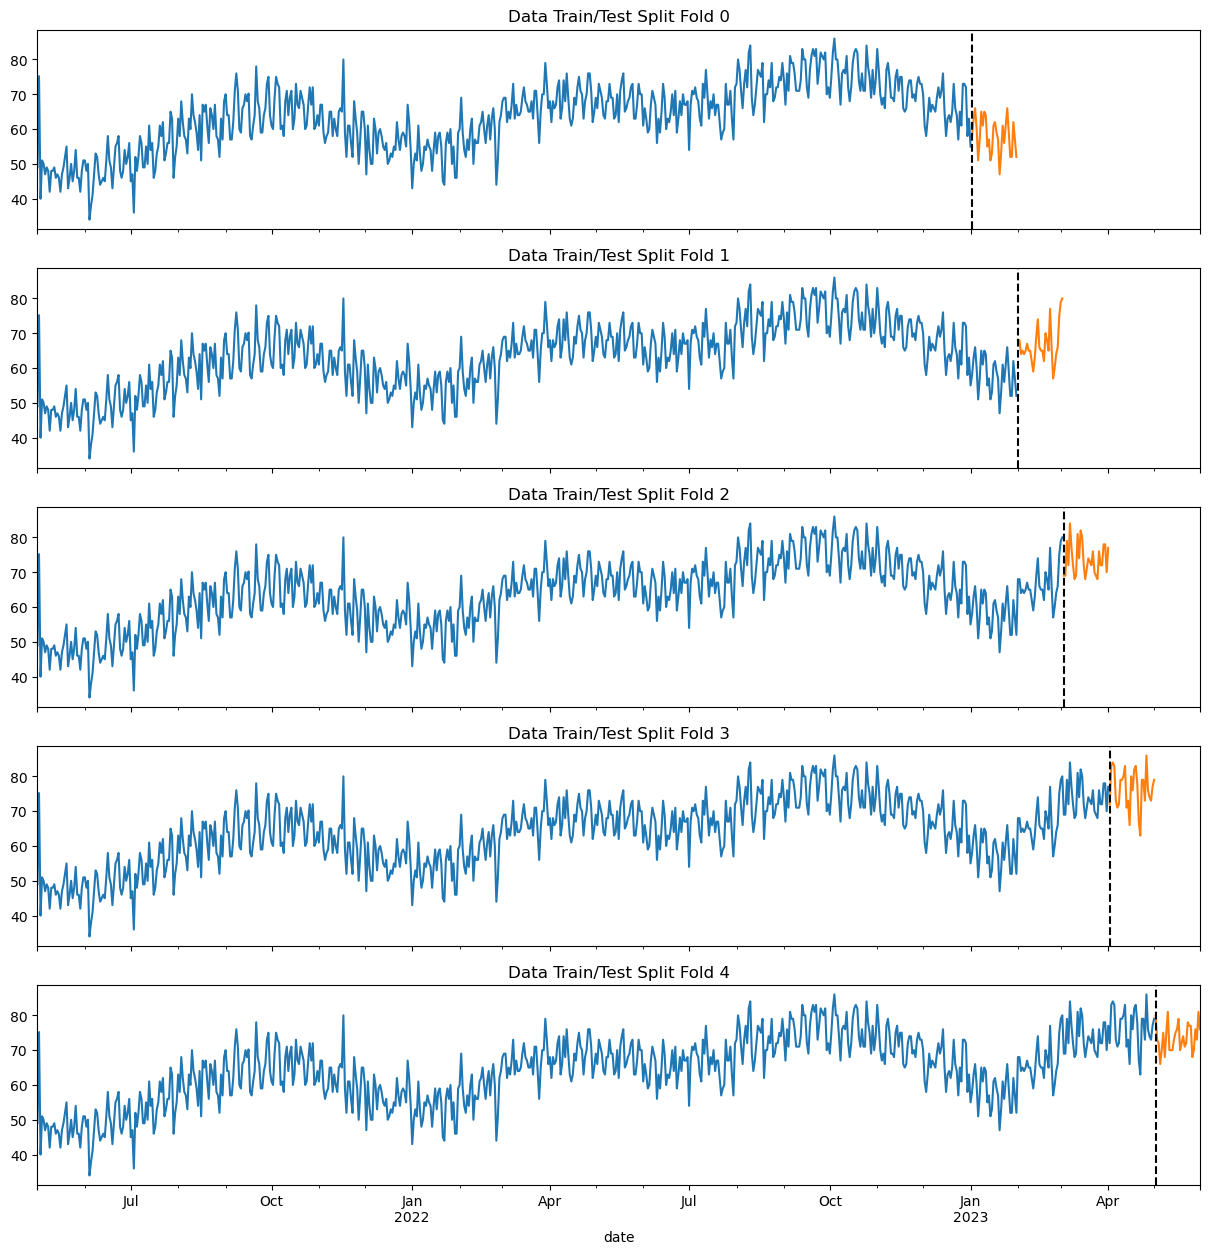

scores:  [0.3342932033436055, 0.5236628469097426, 0.5270819783655156, 0.6917359070411181, 0.6024142800660907]
mean value of scores:  0.5358376431452145
[20:03:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1700181168148/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:64.35068
[100]	validation_0-rmse:24.25432
[200]	validation_0-rmse:9.95090
[300]	validation_0-rmse:5.33337
[400]	validation_0-rmse:4.13107
[500]	validation_0-rmse:3.80104
[600]	validation_0-rmse:3.65711
[700]	validation_0-rmse:3.56706
[800]	validation_0-rmse:3.49446
[900]	validation_0-rmse:3.43201
[999]	validation_0-rmse:3.38520
PÄÄ: 
           date  courier
0   2021-05-01     49.0
1   2021-05-02     75.2
2   2021-05-03     40.0
3   2021-05-04     51.0
4   2021-05-05     50.0
..         ...      ...
756 2023-05-27     70.0
757 2023-05-28     76.0
758 2023-05-29     73.0
759 2023-05-30     81.0
760 2023-05-31     76.0

[761 row

/tmp/ipykernel_399/1812478501.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_xgb = pd.concat([forecast_xgb,


In [22]:
# Modelling and predicting the courier partners
final_df, score_prophet, score_xgb = modelling(data, plot=plot)

# **Results**

After building and evaluating the models, here’s how they performed:

## **Model Performance**

| Metric      | XGBoost | Prophet  |
|-------------|---------|----------|
| **R² Score**| 0.535   | 0.832    |

- **Prophet** performed better, with a higher R² score.
- Prophet explained 83.2% of the variation in the data, compared to XGBoost's 53.5%.

## **Visual Comparison**
- **XGBoost**:
  - Struggled to capture seasonal trends and sudden changes in the data.
  - Worked better for short-term predictions but was less reliable for longer forecasts.
- **Prophet**:
  - Captured seasonal patterns and trends effectively.
  - Produced smoother and more accurate forecasts over time.

Below is a chart comparing the actual values with the predictions from both models.


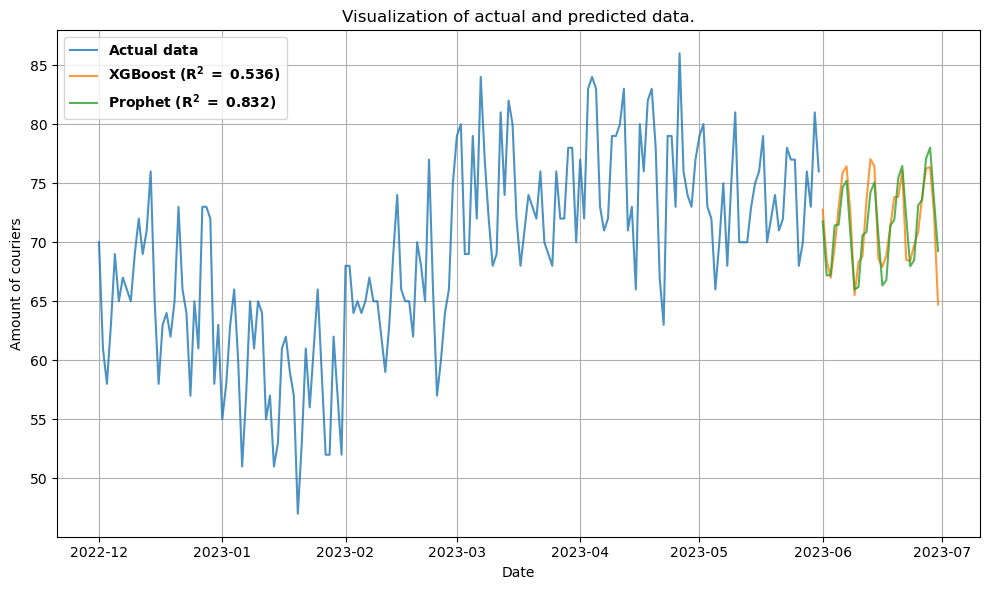

In [23]:
# Post EDA
post_EDA(final_df, score_prophet, score_xgb)

# **Conclusion**

This project focused on forecasting the number of courier partners online for the next 30 days. Here’s what we found:

1. **Prophet performed better**:
   - R² Score: 0.832 (Prophet) vs. 0.535 (XGBoost).
   - Prophet was better at handling trends and seasonality.

2. **XGBoost’s Limitations**:
   - While XGBoost worked well for short-term forecasts, it didn’t handle seasonal patterns as effectively as Prophet.
3. **Business Value**:
   - Reliable forecasts help in planning resources and managing couriers during busy or quiet times.
   - Understanding seasonal trends can
   improve operational decisions for peak periods like holidays or bad weather.

These results show that Prophet is the better choice for this specific forecasting task.


# **Suggestions for Further Improvements**

To make the models even better, we can explore the following ideas:

1. **Add More Features**:
   - Include additional data like:
     - Public holidays.
     - Big promotional events (e.g., sales or discounts).
     - Traffic conditions or major local events.
   - These factors could affect how many couriers are online.

2. **Try Other Models**:
   - Use advanced models like:
     - **LSTMs (Long Short-Term Memory)**: These are deep learning models made for time-series data.
     - **ARIMA or SARIMA**: Great for capturing trends and seasonality.

3. **Longer Forecasts**:
   - Predict beyond 30 days (e.g., for 3 months or 6 months).
   - Test how well the models work for longer periods.

4. **Tune the Models**:
   - Fine-tune the settings for both Prophet and XGBoost to get even better results.
   - For XGBoost, this means adjusting parameters like the learning rate or tree depth.

5. **Combine Both Models**:
   - Use a mix of Prophet and XGBoost to create a combined (ensemble) model.
   - Prophet can handle trends, while XGBoost can help with short-term changes.

6. **Make the Models More Robust**:
   - Test how the models perform with missing or unusual data, like sudden spikes or drops in courier numbers.
   - This ensures the models can handle real-world scenarios.

These improvements could lead to more accurate and reliable forecasts for Wolt’s operations.
